In [1]:
%matplotlib inline
from fish.ephys.ephys import load, chop_trials, estimate_onset
from fish.image.zds import ZDS
from fish.util.fileio import read_image
from skimage.transform import resize, downscale_local_mean
from skimage.exposure import rescale_intensity as rescale
from skimage.io import imsave, imread
from scipy.io import loadmat
from fish.util.plot import proj_fuse
from scipy.ndimage.filters import gaussian_filter1d, median_filter
from functools import partial
from dask.array import coarsen
from dask.distributed import Client
from dask.delayed import delayed

import flika as flk
flk.start_flika()
from flika.window import Window as flw

from glob import glob
from h5py import File

import matplotlib.gridspec as gridspec
from scipy.stats import zscore
from scipy.signal import decimate
import matplotlib.pyplot as plt
plt.style.use('npg')

import sys
import json
import pathlib as pl
from os.path import sep

import numpy as np

Starting flika
Starting flika inside IPython


In [1]:
def offset_colorbar(fig, axis, **kwargs):
    from matplotlib.pyplot import colorbar
    pos = axis.get_position()
    b = colorbar(axis.get_images()[0], cax=fig.add_axes([pos.x0 + pos.width, pos.y0, .01, pos.height/2]), **kwargs)
    b.outline.set_linewidth(0)
    return b    

def mdp(data, axis, cmap):
    from skimage.exposure import rescale_intensity as rescale
    from numpy import argmax, linspace, zeros
    # max project to get intensity, then use depth to set color
    mx = rescale(data.max(axis).astype('float'), out_range=(0,1))
    remapped = zeros((*mx.shape[1:], 4))
    dp = argmax(data, axis)    
    col_array = cmap(linspace(0, 1, data.shape[axis]))
    remapped = (col_array[dp,:].transpose(2,1,0) * mx.T).transpose(2,1,0)
    
    return remapped

def stackline(x_axis, array, axis, scale, **kwargs):
    for ind, val in enumerate(array):
        axis.plot(x_axis, val - ind * scale, **kwargs)
    axis.set_xlim(x_axis.min(), x_axis.max())

def trigger_data(triggers, window, fnames, average=False, parallelism=None):
    from fish.util.fileio import read_image    
    from numpy import array, zeros
    
    sample = read_image(fnames[0])

    if average:
        dims = list(sample.shape)
        dims.insert(0, len(window))
        ims_trial = zeros(dims)
    else: 
        dims = list(sample.shape)
        dims.insert(0, len(window))
        dims.insert(0, len(triggers))
        ims_trial = zeros(dims)
    
    for ind, trig in enumerate(triggers):        
        tr = read_image(array(fnames)[trig + window],roi=None, parallelism=parallelism)
        
        if average:
            ims_trial += tr.astype('float32')/len(triggers)

        else:
            ims_trial[ind] = tr
    
    return ims_trial

def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = np.squeeze(f[head_name][k][:])
    return data

def triggered_behavior(triggers, window, swims):
    from numpy import array
    trig_ep = []
    for trig in triggers:
        trig_ep.append(swims[trig + window])
    return array(trig_ep)

def standard_clim(axes, clim_scaling=(1,1)):
    clim = np.array([ax.get_images()[0].get_clim() for ax in axes])
    clim = (clim.min() * clim_scaling[0], clim.max() * clim_scaling[1])
    [ax.get_images()[0].set_clim(clim) for ax in axes]

def bz2reader(fname, dims):
        from numpy import frombuffer 
        from bz2 import open
        
        with open(fname) as f:
            result = frombuffer(f.read(), dtype = 'int16').reshape(dims)
        
        return result    
    
def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation    
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

def mydff(v, fs_im):
    from fish.image.vol import dff
    camera_offset = 100
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

In [3]:
potential_paths = ['/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',
                   '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/',
                  '/nrs/ahrens/Yu/SPIM/active_dataset/20141209_1_1_cy74_GAD_1_1_simpleGU_20141209_154521/']

In [6]:
dirs = {}
dirs['base_raw'] = potential_paths[-1]
exp_name = dirs['base_raw'].split(sep)[-2]
dirs['ephys'] = dirs['base_raw'] + 'swims/'
dirs['raw'] = dirs['base_raw'] + 'raw/'
exp = ZDS(dirs['raw'])
dirs['reg'] = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
dims = exp.shape[1:]
if exp.data is None:
    from dask.array import stack, from_delayed
    rdr = delayed(lambda v: bz2reader(v, dims))
    exp.data = stack([from_delayed(rdr(fn), exp.shape[1:], 'uint16') for fn in exp.files])

dirs['base_output'] = '/groups/ahrens/ahrenslab/davis/tmp/' + exp.metadata['data_header'] + sep
dirs['output'] = '/groups/ahrens/ahrenslab/davis/data/ngm/'
fs_im = exp.metadata['volume_rate']

dz = exp.metadata['z_step']
um_per_pixel = .40625

data = exp.data

medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data.map_blocks(medfilt)    

print('calculating reference image')
#anat_ref = data_filt[data_filt.shape[0]//2 + np.arange(-5,5)].mean(0).compute(scheduler='threads')

reg_path = dirs['reg'] + 'regparams_affine.npy'
try: 
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    shifts = None    
    print('No valid regparams found. They will be estimated')
data.shape

print(len(exp.files))

Could not create dask aray from images. Check their format.
calculating reference image
5150


In [13]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

In [7]:
from dask_jobqueue import LSFCluster
cluster = LSFCluster(queue='normal',
                     project='bennettd',
                     walltime='01:30',
                     cores=1,
                     local_directory='/scratch/bennettd/',
                     memory='16GB')
client = Client(cluster)
client

<Client: scheduler='tcp://10.36.111.11:39387' processes=0 cores=0>

In [10]:
if shifts is None:
    import time
    cluster.start_workers(320)
    time.sleep(10)
    ref_mx_bc = client.scatter(anat_ref.max(0), broadcast=True)
    affines = data_filt.max(1).map_blocks(lambda a,b: reg(b, a), ref_mx_bc, dtype='float32', chunks=(1,2,2)).compute()
    cluster.stop_all_jobs()
    np.save(reg_path, affines)
    shifts = -affines[:,:-1,-1]    

In [14]:
data = exp.data
roi = (slice(None), slice(0,None), slice(None), slice(None))
data_tx = data[roi].map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
data_filt = data_tx.map_blocks(lambda v: median_filter(v, size=(1,1,3,3)))
ds_xy = 2
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

In [15]:
cluster.start_workers(100)

In [16]:
persisted = data_dff.persist()

In [17]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0][:exp.shape[0]]

In [18]:
gu_inds = cam[np.squeeze(loadmat(dirs['ephys'] + 'GU_onset.mat')['GU_onset'])]
#ngu_inds = loadmat(dirs['ephys'] + 'pause_start.mat')['pause_start']
frames_gu = epdat['frame'][gu_inds].astype('int')
#frames_ngu = epdat['frame'][ngu_inds].astype('int')

def trim_trials(window, trials, total_duration):
    from numpy import array
    keep = array([f + window[0] > 0 and (f + window[-1] < (total_duration - 1)) for f in trials])
    return trials[keep]

window_im = np.arange(-10, 21)

frames_gu = trim_trials(window_im, frames_gu, exp.shape[0])
#frames_ngu = trim_trials(window_im, frames_ngu, len(fnames))
print(frames_gu)

[ 143  301  439  575  702  849 1037 1131 1326 1431 1571 1745 1864 2019
 2190 2360 2455 2621 2761 2893 3068 3360 3555 3641 3777 3913 4062 4210
 4362 4517 5000]


In [ ]:
t_points = [10, 20, 30]
fig, axs = plt.subplots(nrows=1, sharex=True, dpi=300)
window = np.arange((window_im[0] / fs_im) * 6000, (window_im[-1] / fs_im) * 6000).astype('int')
x_axis_ep = window / 6000

trig_ep_gu = triggered_behavior(gu_inds, window, swims)
scale = .001

stackline(x_axis_ep, trig_ep_gu, axis=axs, scale=scale, color='k', linewidth=1)
axs.title.set_text('Giving up trials')
axs.set_xlabel('Time [s]')

Text(0.5, 0, 'Time [s]')

In [ ]:
trig_arr = frames_gu + window_im.reshape(-1,1)

In [ ]:
trig_arr.shape

In [22]:
tr_mean = persisted.vindex[trig_arr].mean(1).compute()

In [52]:
from skimage.io import imsave
imsave(dirs['base_output'] + 'gu_triggered_average.tif', tr_mean, imagej=True)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /groups/ahrens/ahrenslab/davis/tmp/20141209_1_1_cy74_GAD_1_1_simpleGU/gu_triggered_average.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [54]:
dirs['base_output'] + 'gu_triggered_average.tif'

'/groups/ahrens/ahrenslab/davis/tmp/20141209_1_1_cy74_GAD_1_1_simpleGU/gu_triggered_average.tif'

In [26]:
tr_mean.shape

(31, 35, 542, 1024)

In [31]:
flw(tr_mean[:,23])

In [27]:
gu_pt = np.where(window_im == 0)[0][0]
diff_map = tr_mean[gu_pt:].mean(0) - tr_mean[:gu_pt].mean(0)

In [28]:
flw(diff_map)

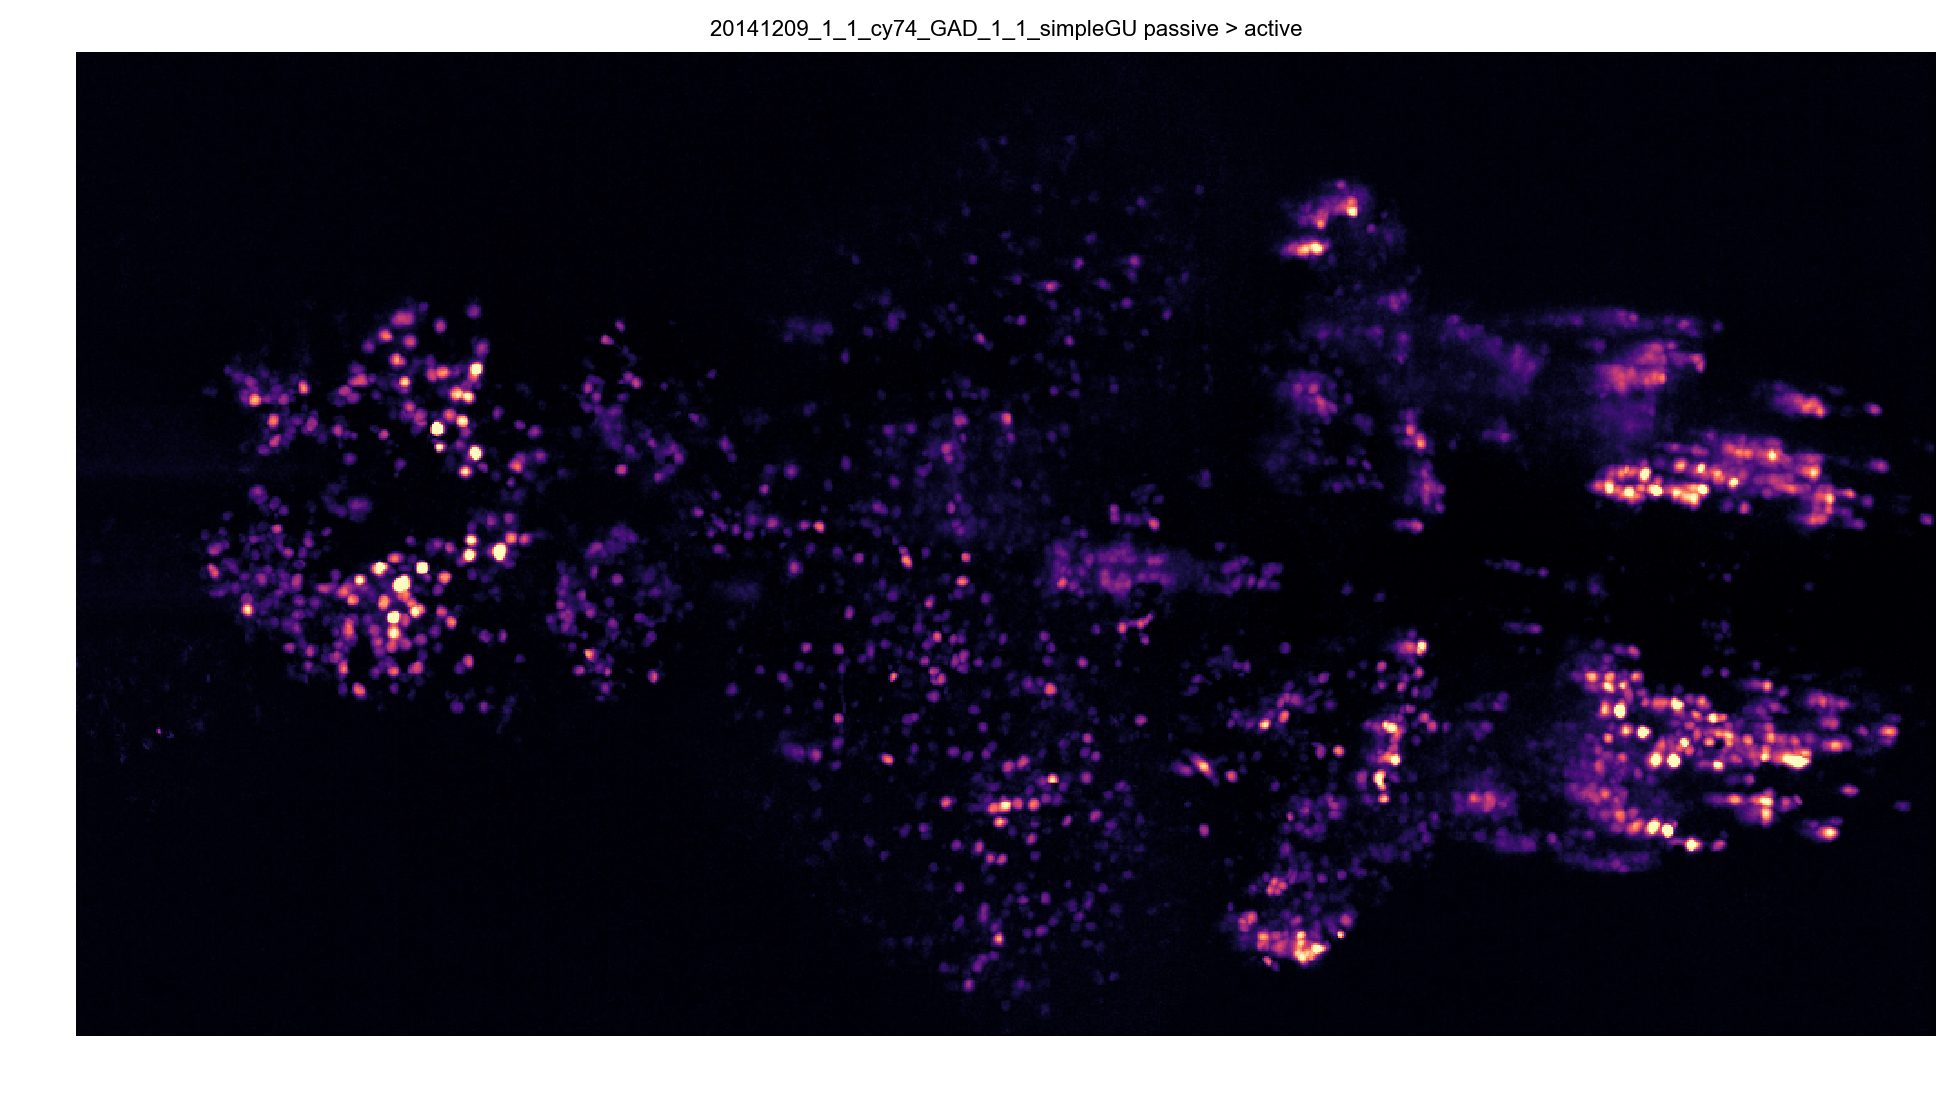

In [46]:
fig, axs = plt.subplots(figsize=(12,12), dpi=200)
axs.imshow(diff_map.max(0), clim=(0,.2), cmap='magma')
axs.axis('off')
axs.title.set_text(exp.metadata['data_header'] + ' passive > active')

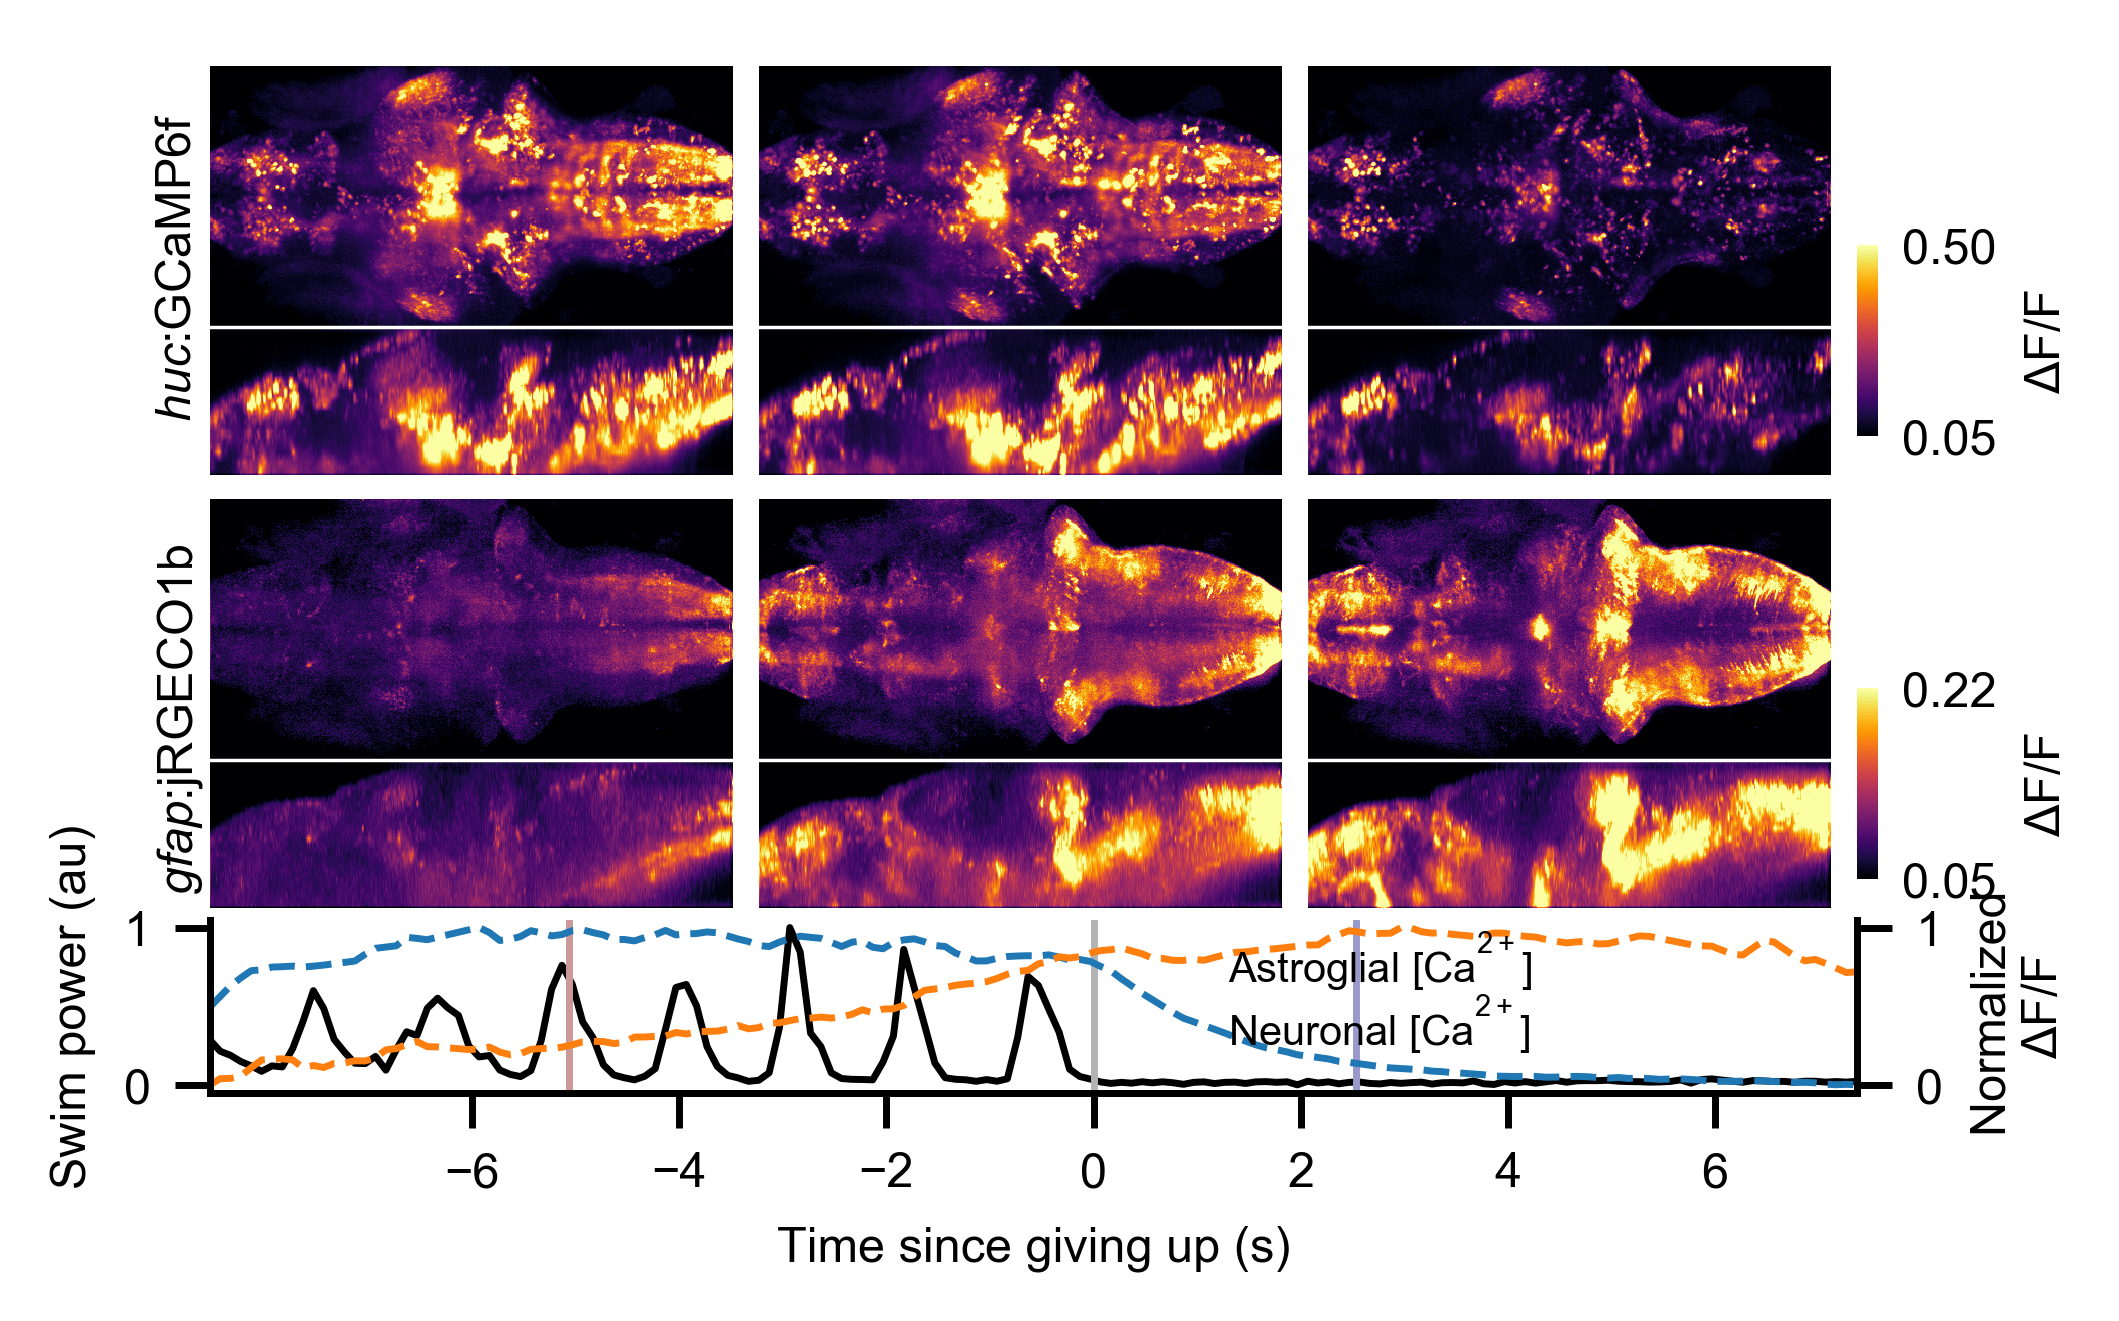

In [12]:
fontsize = 7
to_show = [-8, 0, 4]

# clims for the single-trial example
genotypes = ['n', 'g']
genotype_labels = dict(g=r'$gfap$:jRGECO1b', n=r'$huc$:GCaMP6f')

dff_label = r'$\mathregular {\Delta F/F}$'

timemode=''
if hasattr(to_show[0], '__iter__'):
    timemode='ranges'    
    t_points = []
    for r_ in to_show:
        t_points.append(np.array([np.where(window_im == t)[0][0] for t in r_]))
else:
    timemode='points'
    t_points = [np.where(window_im == t)[0][0] for t in to_show]

vol = trig_gu
#triggers = gu_inds

dims= vol.shape

cmap='inferno'
x_axis_im = window_im / fs_im
window_ep = np.arange(x_axis_im[0] * 6000, x_axis_im[-1] * 6000).astype('int')
ds_ep = 150
x_axis_ep = window_ep[::ds_ep] / 6000

# load mika's matrix of interpolated brain averages
mika_interp = loadmat('/groups/ahrens/ahrenslab/davis/data/ngm/trigger_averages_intp_v3.mat')
x_axis_ep = np.squeeze(mika_interp['time'])
start, stop = -8,8, 
tr = slice(np.where(x_axis_ep > start)[0][0], np.where(x_axis_ep > stop)[0][0])

x_axis_ep = x_axis_ep[tr] - 1/fs_im
trig_ep_gu = rescale(np.nanmedian(mika_interp['powr_neur_glia_intp'][tr,:,0], 1), out_range=(0,1))
mean_n_tr = rescale(np.nanmedian(mika_interp['powr_neur_glia_intp'][tr,:,1], 1), out_range=(0,1))
mean_g_tr = rescale(np.nanmedian(mika_interp['powr_neur_glia_intp'][tr,:,2], 1), out_range=(0,1))

#mean_n_tr = rescale_intensity(vol[:, :, rois['n'][0], rois['n'][1]].mean((1,2,3)), out_range=(0,1))
#mean_g_tr = rescale_intensity(vol[:, :, rois['g'][0], rois['g'][1]].mean((1,2,3)), out_range=(0,1))

#trig_ep_gu = median_filter(np.percentile(triggered_behavior(triggers, window_ep, swims), 100, axis=0), size=1000)
#trig_ep_gu = rescale_intensity(trig_ep_gu, out_range=(0,1))[::ds_ep]
#trig_ep_gu = rescale_intensity(decimate(zscore(trig_ep_gu), ds_ep, ftype='fir', n=300), out_range=(0,1))

scale = 1

fig_ims = plt.figure(figsize=(scale * (8.5 / 2), scale * (11 / 4)), dpi=500)
gs = gridspec.GridSpec(3, len(t_points), height_ratios=[2.5, 2.5, 1], hspace=None, wspace=0)
axs_ims = []
axs_ims.append([plt.subplot(gs[0,t]) for t in range(len(t_points))])
axs_ims.append([plt.subplot(gs[1,t]) for t in range(len(t_points))])

axs_ts_ep = plt.subplot(gs[-1,:])

colors = [(.8,.6,.6), (.7,.7,.7), (.6,.6,.8), (.3, .3, .3)]

clims = dict(g=[.05, .22], n=[.05, .5])

# plot images
for ind, t in enumerate(t_points):        
    for ind_g, val in enumerate(genotypes):
        cur_axs = axs_ims[ind_g][ind]
        cur_axs.axis('off')
        
        if timemode == 'points':
            to_show = my_proj(vol[t][rois[val][::-1]], np.max, aspect=aspect)
        elif timemode == 'ranges':
            to_show = my_proj(vol[t].max(0)[rois[val][::-1]], np.max, aspect=aspect)
        
        axs_ims[ind_g][ind].imshow(to_show, cmap=cmap, clim=clims[val], origin='lower')
        # draw a white line at the boundary between the projections
        axs_ims[ind_g][ind].plot([0, to_show.shape[-1]], 2*[vol.shape[1] * aspect[0]], color='w', linewidth=.5)

        if ind == 0:
            cur_axs.text(-.1 * np.diff(cur_axs.get_xlim())[::-1], .8 * np.diff(cur_axs.get_ylim())[::-1], genotype_labels[val], color='k', fontsize=fontsize, rotation=90)
           # cur_axs.set_ylabel(genotypes[val])
    
# plot corresponding timeseries
axs_ts_ep.plot(x_axis_ep, trig_ep_gu, color='k', linewidth=1)

# plot mean of glia and neurons
axs_ts_im = axs_ts_ep.twinx()
axs_ts_im.plot(x_axis_ep, mean_n_tr, linewidth=1, linestyle='--');
axs_ts_im.plot(x_axis_ep, mean_g_tr, linewidth=1, linestyle='--');
axs_ts_im.text(1.3, .25, r'Neuronal [$\mathregular {Ca^{2+}}$]', fontsize=6)
axs_ts_im.text(1.3, .65, r'Astroglial [$\mathregular {Ca^{2+}}$]', fontsize=6)
axs_ts_im.yaxis.set_label_position("right")
axs_ts_im.set_ylabel('Normalized \n{0}'.format(dff_label))
axs_ts_im.spines['right'].set_visible(True)
axs_ts_im.set_yticks([0,1])
axs_ts_ep.set_yticks([0,1])
axs_ts_ep.set_xticks(range(-6, 8, 2))

axs_ts_ep.set_ylabel('Swim power (au)', fontsize=fontsize)
axs_ts_ep.set_xlabel('Time since giving up (s)', fontsize=fontsize)

axs_ts_im.set_xlim(x_axis_ep[0], x_axis_ep[-1])
axs_ts_ep.set_xlim(x_axis_ep[[0,-1]])

if timemode == 'points':
    [axs_ts_im.axvline(window_im[t] / fs_im, zorder=0, linewidth=1, color=colors[ind_t]) for ind_t, t in enumerate(t_points)]
elif timemode =='ranges':
    [axs_ts_im.axvspan(*window_im[t[[0,-1]]] / fs_im, zorder=0, color=colors[ind_t]) for ind_t, t in enumerate(t_points)]

for ind_g, val in enumerate(genotypes):
    b = offset_colorbar(fig_ims, axs_ims[ind_g][-1], ticks=clims[val])    
    b.ax.set_ylabel(dff_label, fontsize=fontsize, fontname='Arial')
    b.ax.tick_params(width=0)
    b.ax.tick_params(length=0)
plt.subplots_adjust(hspace=0, wspace=0)


plt.savefig(dirs['output'] + '{0}_triggered_average_gu.pdf'.format(exp_name))
with File(dirs['output'] + '{0}_triggered_average_metadata.h5'.format(exp_name),'w') as f:
    f['glia_mean'] = mean_g
    f['neuron_mean'] = mean_n
    f['experiment_name'] = exp_name
    f['average_window_frames'] = window_im
    f['trigger_frames'] = frames_gu
    f['fs_im_Hz'] = fs_im 

In [ ]:
from functools import partial
tmp = trig_ep_gu = triggered_behavior(triggers, window_ep, swims)
fig, axs = plt.subplots(figsize=(6,12), dpi=300, nrows=3)
fs_ep = 6000
kw = 6000 
kern = np.ones(kw)
kern /= kern.sum()
smoother = partial(np.convolve, kern, mode='same')
smoothed = np.apply_along_axis(smoother,1, tmp)
x_axis = window_ep / fs_ep
x_axis_smoothed = x_axis
axs[0].plot(x_axis, 1000 * tmp.T + np.arange(tmp.shape[0]));

axs[1].plot(x_axis_smoothed, 10000 * smoothed.T + np.arange(tmp.shape[0]));
inds = np.arange(-6 * fs_ep, 6 * fs_ep, kw) + np.where(window_ep > 0)[0][0] + kw//2
axs[2].plot(x_axis_smoothed[inds], smoothed.mean(0)[inds], color='k')
num_trials = tmp.shape[0]
#[axs[2].scatter((x_axis_smoothed[i],) * num_trials, smoothed[:,i]) for i in inds]
axs[2].plot(x_axis_smoothed[inds], smoothed.mean(0)[inds] + smoothed.std(0)[inds], color='gray', label='+/-STD')
axs[2].plot(x_axis_smoothed[inds], smoothed.mean(0)[inds] - smoothed.std(0)[inds], color='gray')
axs[2].legend()
[ax.set_xlabel('Time since giving up (s)') for ax in axs]
axs[0].set_ylabel('Raw trials');
axs[1].set_ylabel('Smoothed with {0} s boxcar'.format(kw/fs_ep));
axs[2].set_ylabel('Trial average of smoothed data, sampled at {0} s intervals'.format(kw/fs_ep));